In [1]:
import torch, os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import pandas as pd
import matplotlib.pylab as plt
import numpy as np

pd.set_option("display.max_columns", None)
np.random.seed(42)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
path_csv = "../data/BGR/data_horizons.csv"
path_csv_annotator_ids = '../data/BGR/Kartierer_ID.csv'
path_csv_locations = '../data/BGR/STANDORT.csv'
path_horizons_simple = '../data/BGR/Vereinfachung_Horizontsymbole.csv'
#path_pictures = "/Users/felix/Library/CloudStorage/Dropbox/data/BGR-Data-Bodenhorizonte/Profilbilder/"
path_pictures = "../data/BGR/Profilbilder/"
path_images = "images"
path_masks = "masks"

In [12]:
df = pd.read_csv(path_csv)
print(len(df.index))
df = df.dropna(subset=['Bodenart'])
print(len(df.index))
df#.head()

15207
15151


,Point,HorizontID,Obergrenze,Untergrenze,Horizontsymbol,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,Unnamed: 11,Bundesland,PointID,Unnamed: 14,profile,max_depth
0,2.0,1.0,0.0,28.0,I; Ap,Sl2,7.5YR 3/2,3.0,C0,h3,Wf4,NaN,SH,2.0,NaN,BB_0541.0,100.0
1,2.0,2.0,28.0,54.0,I; E,Sl2,10YR 3/3,3.0,C0,h2,Wf3,NaN,SH,3.0,NaN,BB_0600.0,90.0
2,2.0,3.0,54.0,68.0,II; Bv,Sl2,7.5YR 4/3,10.0,C0,h1,Wf3,NaN,SH,4.0,NaN,BB_0601.0,100.0
3,2.0,4.0,68.0,96.0,III; Bv-ilCv,fSms,7.5YR 6/4,1.0,C0,h0,Wf2,NaN,SH,5.0,NaN,BB_0659.0,100.0
4,2.0,5.0,96.0,201.0,III; ilCv,mSfs,10YR 7/4,1.0,C0,h0,NaN,NaN,SH,6.0,NaN,BB_0660.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15201,6211.0,3.0,27.0,50.0,I; Bbh+Bs,fSms,5YR 3/2,1.0,C0,h2,Wf3,NaN,NaN,NaN,NaN,NaN,NaN
15202,6211.0,4.0,50.0,70.0,I; Bbs+Bs,fSms,5YR 4/3,1.0,C0,h1,Wf2,NaN,NaN,NaN,NaN,NaN,NaN
15203,6211.0,5.0,70.0,100.0,I; Go-Bbs,fSms,7.5YR 5/4,1.0,C0,h1,Wf6,NaN,NaN,NaN,NaN,NaN,NaN
15204,6211.0,6.0,100.0,130.0,I; Go,fSms,2.5Y 6/4,1.0,C0,h0,Wf4,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df_simple = pd.read_csv(path_horizons_simple)
df_simple.head()

,Horiz,Anzahl im Datensatz,relevanter Anteil = was sinntragend und detektierbar ist - es sind nicht alles gültige Symbole,stark vereinfacht
0,Ap,1762,Ap,Ap
1,Bv,626,Bv,Bv
2,ilCv,620,ilC,Cv
3,elCv,500,elC,Cv
4,Ah,455,Ah,Ah


In [13]:
# Add an extra column to the original dataset with the simplified horizon symbols

# Function to simplify a complex string based on the mapping
def simplify_string(complex_string, mapping_df):
    complex_symb = complex_string.split('; ')[1]
    # Find the matching simplified part in the mapping DataFrame
    simple_symb_series = mapping_df['stark vereinfacht'][mapping_df['Horiz'] == complex_symb]

    # Keep the complex symbol, when there is no simplified alternative
    if not simple_symb_series.empty:
        simple_symb = simple_symb_series.values[0]
    else:
        simple_symb = complex_symb

    return simple_symb

# Apply the simplification function to each row of the 'Horizontsymbol' column
df['Horizontsymbol_einfach'] = df['Horizontsymbol'].apply(lambda x: simplify_string(x, df_simple))

# Reorder the columns
cols = df.columns.tolist()
cols.insert(cols.index('Horizontsymbol') + 1, 'Horizontsymbol_einfach')
cols.pop() # remove the duplicate at the end
df = df[cols]
df

,Point,HorizontID,Obergrenze,Untergrenze,Horizontsymbol,Horizontsymbol_einfach,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,Unnamed: 11,Bundesland,PointID,Unnamed: 14,profile,max_depth,Horizontsymbol_einfach
0,2.0,1.0,0.0,28.0,I; Ap,Ap,Sl2,7.5YR 3/2,3.0,C0,h3,Wf4,NaN,SH,2.0,NaN,BB_0541.0,100.0,Ap
1,2.0,2.0,28.0,54.0,I; E,E,Sl2,10YR 3/3,3.0,C0,h2,Wf3,NaN,SH,3.0,NaN,BB_0600.0,90.0,E
2,2.0,3.0,54.0,68.0,II; Bv,Bv,Sl2,7.5YR 4/3,10.0,C0,h1,Wf3,NaN,SH,4.0,NaN,BB_0601.0,100.0,Bv
3,2.0,4.0,68.0,96.0,III; Bv-ilCv,Bv-Cv,fSms,7.5YR 6/4,1.0,C0,h0,Wf2,NaN,SH,5.0,NaN,BB_0659.0,100.0,Bv-Cv
4,2.0,5.0,96.0,201.0,III; ilCv,Cv,mSfs,10YR 7/4,1.0,C0,h0,NaN,NaN,SH,6.0,NaN,BB_0660.0,100.0,Cv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15201,6211.0,3.0,27.0,50.0,I; Bbh+Bs,Bbh+Bs,fSms,5YR 3/2,1.0,C0,h2,Wf3,NaN,NaN,NaN,NaN,NaN,NaN,Bbh+Bs
15202,6211.0,4.0,50.0,70.0,I; Bbs+Bs,Bbs+Bs,fSms,5YR 4/3,1.0,C0,h1,Wf2,NaN,NaN,NaN,NaN,NaN,NaN,Bbs+Bs
15203,6211.0,5.0,70.0,100.0,I; Go-Bbs,Go-Bbs,fSms,7.5YR 5/4,1.0,C0,h1,Wf6,NaN,NaN,NaN,NaN,NaN,NaN,Go-Bbs
15204,6211.0,6.0,100.0,130.0,I; Go,Go,fSms,2.5Y 6/4,1.0,C0,h0,Wf4,NaN,NaN,NaN,NaN,NaN,NaN,Go


In [4]:
image_dataset = os.listdir(path_pictures)
img_files = pd.DataFrame(image_dataset, columns=['file'])
img_files['Point'] = img_files['file'].str.split("_").map(lambda x: x[1]).astype(float)
img_files.head()

,file,Point
0,BW_5422_Z_1.jpg,5422.0
1,BY_3916_Z_1.jpg,3916.0
2,TH_3030_Z_1.jpg,3030.0
3,BB_0660_Z_1.jpg,660.0
4,NW_2008_Z_1.jpg,2008.0


In [5]:
df = pd.merge(df, img_files, how='inner', on='Point')
df['file'] = df['file'].map(lambda x: os.path.join(path_pictures, x))
df.head()

,Point,HorizontID,Obergrenze,Untergrenze,Horizontsymbol,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,Unnamed: 11,Bundesland,PointID,Unnamed: 14,profile,max_depth,file
0,2.0,1.0,0.0,28.0,I; Ap,Sl2,7.5YR 3/2,3.0,C0,h3,Wf4,NaN,SH,2.0,NaN,BB_0541.0,100.0,../data/BGR/Profilbilder/SH_0002_Z_1.jpg
1,2.0,2.0,28.0,54.0,I; E,Sl2,10YR 3/3,3.0,C0,h2,Wf3,NaN,SH,3.0,NaN,BB_0600.0,90.0,../data/BGR/Profilbilder/SH_0002_Z_1.jpg
2,2.0,3.0,54.0,68.0,II; Bv,Sl2,7.5YR 4/3,10.0,C0,h1,Wf3,NaN,SH,4.0,NaN,BB_0601.0,100.0,../data/BGR/Profilbilder/SH_0002_Z_1.jpg
3,2.0,4.0,68.0,96.0,III; Bv-ilCv,fSms,7.5YR 6/4,1.0,C0,h0,Wf2,NaN,SH,5.0,NaN,BB_0659.0,100.0,../data/BGR/Profilbilder/SH_0002_Z_1.jpg
4,2.0,5.0,96.0,201.0,III; ilCv,mSfs,10YR 7/4,1.0,C0,h0,NaN,NaN,SH,6.0,NaN,BB_0660.0,100.0,../data/BGR/Profilbilder/SH_0002_Z_1.jpg


In [6]:
df_k = pd.read_csv(path_csv_annotator_ids)
df_k = df_k.rename({'PointID':'Point'},axis=1)
df_k.head()

,Point,Aufnehmer
0,2,Kart8
1,3,Kart8
2,4,Kart10
3,5,Kart8
4,6,Kart8


In [7]:
df_loc = pd.read_csv(path_csv_locations, encoding='unicode_escape')
df_loc = df_loc.rename({'PointID':'Point'},axis=1)
df_loc.head()

,Point,Bundesland,Probenahme_Monat,Probenahme_Jahr,xcoord,ycoord,Bodenklimaraum_Name,Landnutzung,BZE_Moor,Hauptbodentyp,BodenVarTypSub,GrundwaStufe,GrundwaStand,Moormaechtigkeit,Torfmaechtigkeit,Neigung,Exposition,Woelbung,Reliefformtyp,LageImRelief,KV_0_30,KV_30_100
0,2,SH,11,2015,462216.1283,6079359.775,Marsch - Nord,A,0,YE,YE/BB,0,>200,0.0,0.0,N0,NaN,GG,V,Z,81.89,54.19
1,3,SH,6,2016,480546.9384,6079739.216,Marsch - Nord,G,0,MD,MDn,GWS4,135,0.0,0.0,N0,NaN,GG,TSF,Z,71.62,59.74
2,4,SH,8,2018,484922.3074,6080011.471,Marsch - Nord,A,0,MK,MKn,GWS4,105,0.0,0.0,N1,NE,GG,TH,Z,65.60,120.40
3,5,SH,10,2015,497355.9905,6079646.589,Marsch - Nord,G,0,RQ,p2RQ/GG-PP,GWS4,180,0.0,0.0,N0.2,SS,GG,KSF,K,88.82,220.87
4,6,SH,10,2015,505020.3377,6080401.37,Geest - Nord,G,0,YU,aGGe-YU,GWS4,140,0.0,0.0,N0,NaN,GG,TSF,Z,62.97,84.35


In [8]:
df = pd.merge(df, df_k, how='inner', on='Point')

In [9]:
df_loc['Point'] = pd.to_numeric(df['Point'])
df = pd.merge(df, df_loc, how='inner', on='Point')

In [10]:
df[df['ycoord']=='N0'] # invalid ycoord?

,Point,HorizontID,Obergrenze,Untergrenze,Horizontsymbol,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,Unnamed: 11,Bundesland_x,PointID,Unnamed: 14,profile,max_depth,file,Aufnehmer,Bundesland_y,Probenahme_Monat,Probenahme_Jahr,xcoord,ycoord,Bodenklimaraum_Name,Landnutzung,BZE_Moor,Hauptbodentyp,BodenVarTypSub,GrundwaStufe,GrundwaStand,Moormaechtigkeit,Torfmaechtigkeit,Neigung,Exposition,Woelbung,Reliefformtyp,LageImRelief,KV_0_30,KV_30_100
709,24.0,1.0,0.0,32.0,I; Ap,Sl4,10YR 3/3,5.0,C0,h3,Wf3,NaN,SH,155.0,NaN,BB_1319.0,100.0,../data/BGR/Profilbilder/SH_0024_Z_1.jpg,Kart8,GWS3,120,0,0.0,N0,NaN,GG,TS,Z,159.95,118.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
714,24.0,2.0,32.0,50.0,I; Al-Sw,Ls4,2.5Y 5/4,5.0,C0,h1,Wf2,NaN,SH,156.0,NaN,BB_1327.0,80.0,../data/BGR/Profilbilder/SH_0024_Z_1.jpg,Kart8,GWS3,120,0,0.0,N0,NaN,GG,TS,Z,159.95,118.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
719,24.0,3.0,50.0,73.0,II; Bt-Sd,Ls3,10YR 4/4,4.0,C0,h0,Wf1,NaN,SH,158.0,NaN,BB_1329.0,100.0,../data/BGR/Profilbilder/SH_0024_Z_1.jpg,Kart8,GWS3,120,0,0.0,N0,NaN,GG,TS,Z,159.95,118.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
724,24.0,4.0,73.0,152.0,II; Sd,Ls3,2.5Y 5/4,4.0,C0,h0,NaN,NaN,SH,160.0,NaN,BB_1331.0,100.0,../data/BGR/Profilbilder/SH_0024_Z_1.jpg,Kart8,GWS3,120,0,0.0,N0,NaN,GG,TS,Z,159.95,118.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
729,24.0,5.0,152.0,201.0,III; lCv,Ls3,2.5Y 6/3,3.0,C3.4,h0,NaN,NaN,SH,161.0,NaN,BB_1333.0,90.0,../data/BGR/Profilbilder/SH_0024_Z_1.jpg,Kart8,GWS3,120,0,0.0,N0,NaN,GG,TS,Z,159.95,118.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4035,177.0,1.0,0.0,33.0,I; Ap,Su3,10YR 3/2,3.0,C0,h3,Wf5,NaN,BB,1202.0,NaN,BY_4471.0,100.0,../data/BGR/Profilbilder/MV_0177_Z_1.jpg,Kart1,GWS4,110,42,24.0,N0,NaN,GG,TS,Z,251.99,84.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4040,177.0,2.0,33.0,60.0,I; Alh,Su3,10YR 4/3,3.0,C0,h2,Wf5,NaN,BB,1203.0,NaN,BY_4474.0,100.0,../data/BGR/Profilbilder/MV_0177_Z_1.jpg,Kart1,GWS4,110,42,24.0,N0,NaN,GG,TS,Z,251.99,84.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4045,177.0,3.0,60.0,80.0,I; Al-Sw1,Su3,2.5Y 6/2,3.0,C0,h0,Wf3,NaN,NI,1204.0,NaN,BY_4475.0,100.0,../data/BGR/Profilbilder/MV_0177_Z_1.jpg,Kart1,GWS4,110,42,24.0,N0,NaN,GG,TS,Z,251.99,84.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4050,177.0,4.0,80.0,96.0,I; Al-Sw2,Su2,2.5Y 6/4,3.0,C0,h0,Wf3,NaN,NI,1205.0,NaN,BY_4476.0,60.0,../data/BGR/Profilbilder/MV_0177_Z_1.jpg,Kart1,GWS4,110,42,24.0,N0,NaN,GG,TS,Z,251.99,84.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4055,177.0,5.0,96.0,201.0,II; Bt+Sd,Ls3,10YR 6/4,3.0,C0,h0,W0,NaN,NI,1207.0,NaN,BY_4477.0,70.0,../data/BGR/Profilbilder/MV_0177_Z_1.jpg,Kart1,GWS4,110,42,24.0,N0,NaN,GG,TS,Z,251.99,84.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
keep_columns = ['Point',
                'HorizontID',
                'Obergrenze',
                'Untergrenze',
                #'Horizontsymbol',
                'Horizontsymbol_einfach',
                'Bodenart',
                'Bodenfarbe',
                'Steine',
                'Karbonat',
                'Humusgehaltsklasse',
                'Durchwurzelung',
                'max_depth',
                'file',
                'Aufnehmer',
                'Probenahme_Monat',
                'Probenahme_Jahr',
                'xcoord',
                'ycoord',
                'Bodenklimaraum_Name',
                'Landnutzung',
                'BZE_Moor',
                'Hauptbodentyp',
                'BodenVarTypSub',
                'GrundwaStufe',
                'GrundwaStand',
                'Moormaechtigkeit',
                'Torfmaechtigkeit',
                'Neigung',
                'Exposition',
                'Woelbung',
                'Reliefformtyp',
                'LageImRelief',
                'KV_0_30',
                'KV_30_100']

df = df[keep_columns]

df['GrundwaStand'] = df['GrundwaStand'].str.replace('>','').astype(float)
#df['xcoord'] = df['xcoord'].str.replace(',','.').astype(float)
#df['ycoord'] = df['ycoord'].str.replace(',','.').astype(float)
df['ycoord'] = df['ycoord'].str.replace('N0','0').astype(float)
#df['KV_0_30'] = df['KV_0_30'].str.replace(',','.').astype(float)
#df['KV_30_100'] = df['KV_30_100'].str.replace(',','.').astype(float)

df

,Point,HorizontID,Obergrenze,Untergrenze,Horizontsymbol,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,max_depth,file,Aufnehmer,Probenahme_Monat,Probenahme_Jahr,xcoord,ycoord,Bodenklimaraum_Name,Landnutzung,BZE_Moor,Hauptbodentyp,BodenVarTypSub,GrundwaStufe,GrundwaStand,Moormaechtigkeit,Torfmaechtigkeit,Neigung,Exposition,Woelbung,Reliefformtyp,LageImRelief,KV_0_30,KV_30_100
0,2.0,1.0,0.0,28.0,I; Ap,Sl2,7.5YR 3/2,3.0,C0,h3,Wf4,100.0,../data/BGR/Profilbilder/SH_0002_Z_1.jpg,Kart8,11,2015,462216.1283,6079359.775,Marsch - Nord,A,0,YE,YE/BB,0,200.0,0.0,0.0,N0,NaN,GG,V,Z,81.89,54.19
1,2.0,1.0,0.0,28.0,I; Ap,Sl2,7.5YR 3/2,3.0,C0,h3,Wf4,100.0,../data/BGR/Profilbilder/SH_0002_Z_1.jpg,Kart8,6,2016,480546.9384,6079739.216,Marsch - Nord,G,0,MD,MDn,GWS4,135.0,0.0,0.0,N0,NaN,GG,TSF,Z,71.62,59.74
2,2.0,1.0,0.0,28.0,I; Ap,Sl2,7.5YR 3/2,3.0,C0,h3,Wf4,100.0,../data/BGR/Profilbilder/SH_0002_Z_1.jpg,Kart8,8,2018,484922.3074,6080011.471,Marsch - Nord,A,0,MK,MKn,GWS4,105.0,0.0,0.0,N1,NE,GG,TH,Z,65.60,120.40
3,2.0,1.0,0.0,28.0,I; Ap,Sl2,7.5YR 3/2,3.0,C0,h3,Wf4,100.0,../data/BGR/Profilbilder/SH_0002_Z_1.jpg,Kart8,10,2015,497355.9905,6079646.589,Marsch - Nord,G,0,RQ,p2RQ/GG-PP,GWS4,180.0,0.0,0.0,N0.2,SS,GG,KSF,K,88.82,220.87
4,2.0,1.0,0.0,28.0,I; Ap,Sl2,7.5YR 3/2,3.0,C0,h3,Wf4,100.0,../data/BGR/Profilbilder/SH_0002_Z_1.jpg,Kart8,10,2015,505020.3377,6080401.370,Geest - Nord,G,0,YU,aGGe-YU,GWS4,140.0,0.0,0.0,N0,NaN,GG,TSF,Z,62.97,84.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16798,1118.0,5.0,98.0,150.0,III; Sd1,Ls3,2.5Y 5/3,2.0,C0,h0,NaN,NaN,../data/BGR/Profilbilder/ST_1118_Z_1.jpg,Kart8,11,2011,450265.8395,5448367.068,Rheinebene und Nebentäler,A,0,YK,YKn,0,200.0,0.0,0.0,N1,EE,XV,T,Z,38.99,47.26
16799,1118.0,5.0,98.0,150.0,III; Sd1,Ls3,2.5Y 5/3,2.0,C0,h0,NaN,NaN,../data/BGR/Profilbilder/ST_1118_Z_1.jpg,Kart8,6,2012,522076.9633,5930456.114,Elbe-Weser-Dreieck / sandige Böden,G,0,PP,GG-PP,GWS4,110.0,0.0,0.0,N0,NaN,GG,TSF,T,117.59,87.72
16800,1118.0,6.0,150.0,201.0,III; Sd2,Ls4,2.5Y 5/4,2.0,C0,h0,NaN,NaN,../data/BGR/Profilbilder/ST_1118_Z_1.jpg,Kart8,10,2011,448236.4426,5454486.160,Rheinebene und Nebentäler,A,0,TC,vLL-TC,0,200.0,0.0,0.0,N0.1,NaN,XX,V,Z,37.83,41.80
16801,1118.0,6.0,150.0,201.0,III; Sd2,Ls4,2.5Y 5/4,2.0,C0,h0,NaN,NaN,../data/BGR/Profilbilder/ST_1118_Z_1.jpg,Kart8,11,2011,450265.8395,5448367.068,Rheinebene und Nebentäler,A,0,YK,YKn,0,200.0,0.0,0.0,N1,EE,XV,T,Z,38.99,47.26


In [12]:
#from ydata_profiling import ProfileReport
#profile = ProfileReport(df.drop('file', axis=1), title="Profiling Report")
#profile.to_file("./BGR/bgr_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

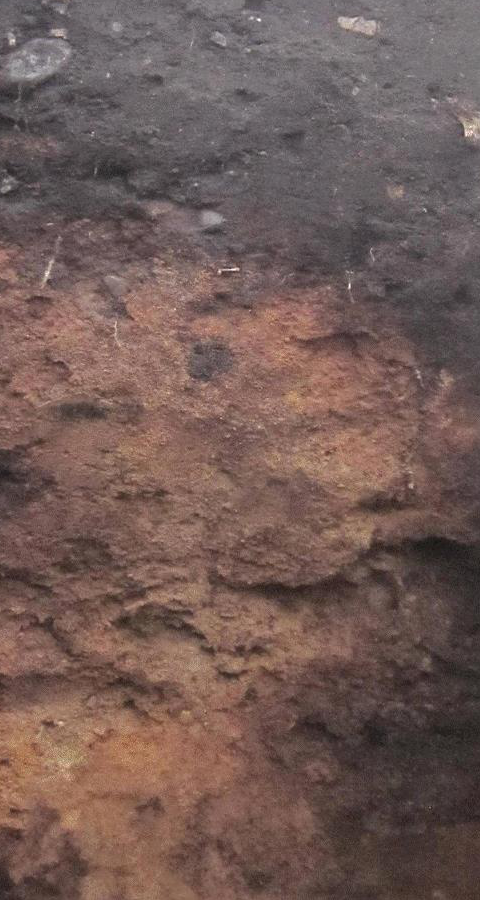

In [13]:
# Lade das Bild
#image = Image.open(os.path.join(path_pictures,df['file'][600]))
image = Image.open(os.path.join(df['file'][600]))

x_len = 240
y_len = 450

# Definiere den Bereich, der ausgeschnitten werden soll (left, upper, right, lower)
# Beispiel: Ein Ausschnitt von (50, 50) bis (200, 200)
# left = 50
# upper = 50
# right = 200
# lower = 200
# crop_area = (left, upper, right, lower)

center_x, center_y = int(image.size[0] / 2), int(image.size[1] / 2)

left = center_x - x_len
right = center_x + x_len
upper = center_y - y_len
lower = center_y + y_len
crop_area = (left, upper, right, lower)

# Schneide den Bereich aus
cropped_image = image.crop(crop_area)

# Zeige den ausgeschnittenen Bereich
cropped_image

In [14]:
# Definiere die Größe des rechteckigen Ausschnitts
crop_width = 240
crop_height = 440

min_labels = 10
label = 'Bodenart'
feature_columns = ['xcoord','ycoord']

vision_backbone = 'WinKawaks/vit-small-patch16-224'

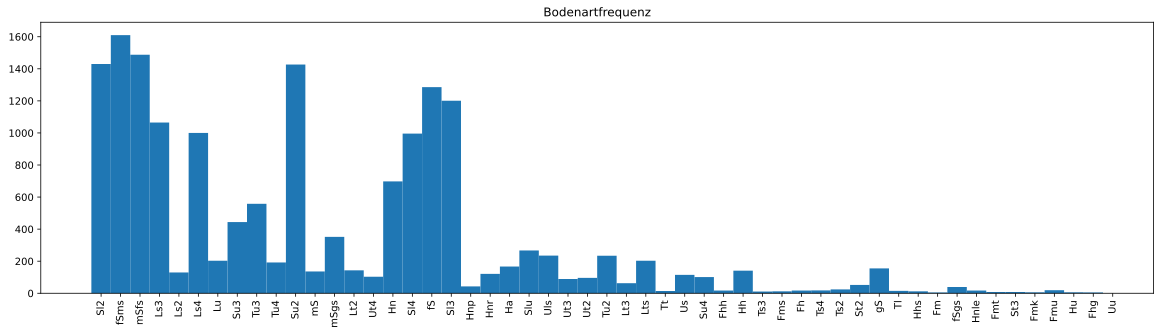

In [15]:
counts = df[label].value_counts()
plt.figure(figsize=(20, 5))
plt.hist(df[label], bins = np.arange(len(counts))-0.5)
plt.title('Bodenartfrequenz')
plt.xticks(rotation='vertical')
plt.show()

In [16]:
counts[counts<min_labels] = np.nan
df[label] = df[label].replace(counts.index, range(len(counts))) # one-hot encode label vector for Bodenart
df = df.dropna(subset= feature_columns + [label])
df[label] = df[label].astype(int)
df.head()

/tmp/ipykernel_46655/1955297243.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[label] = df[label].replace(counts.index, range(len(counts))) # one-hot encode label vector for Bodenart


,Point,HorizontID,Obergrenze,Untergrenze,Horizontsymbol,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,max_depth,file,Aufnehmer,Probenahme_Monat,Probenahme_Jahr,xcoord,ycoord,Bodenklimaraum_Name,Landnutzung,BZE_Moor,Hauptbodentyp,BodenVarTypSub,GrundwaStufe,GrundwaStand,Moormaechtigkeit,Torfmaechtigkeit,Neigung,Exposition,Woelbung,Reliefformtyp,LageImRelief,KV_0_30,KV_30_100
0,2.0,1.0,0.0,28.0,I; Ap,2,7.5YR 3/2,3.0,C0,h3,Wf4,100.0,../data/BGR/Profilbilder/SH_0002_Z_1.jpg,Kart8,11,2015,462216.1283,6079359.775,Marsch - Nord,A,0,YE,YE/BB,0,200.0,0.0,0.0,N0,NaN,GG,V,Z,81.89,54.19
1,2.0,1.0,0.0,28.0,I; Ap,2,7.5YR 3/2,3.0,C0,h3,Wf4,100.0,../data/BGR/Profilbilder/SH_0002_Z_1.jpg,Kart8,6,2016,480546.9384,6079739.216,Marsch - Nord,G,0,MD,MDn,GWS4,135.0,0.0,0.0,N0,NaN,GG,TSF,Z,71.62,59.74
2,2.0,1.0,0.0,28.0,I; Ap,2,7.5YR 3/2,3.0,C0,h3,Wf4,100.0,../data/BGR/Profilbilder/SH_0002_Z_1.jpg,Kart8,8,2018,484922.3074,6080011.471,Marsch - Nord,A,0,MK,MKn,GWS4,105.0,0.0,0.0,N1,NE,GG,TH,Z,65.60,120.40
3,2.0,1.0,0.0,28.0,I; Ap,2,7.5YR 3/2,3.0,C0,h3,Wf4,100.0,../data/BGR/Profilbilder/SH_0002_Z_1.jpg,Kart8,10,2015,497355.9905,6079646.589,Marsch - Nord,G,0,RQ,p2RQ/GG-PP,GWS4,180.0,0.0,0.0,N0.2,SS,GG,KSF,K,88.82,220.87
4,2.0,1.0,0.0,28.0,I; Ap,2,7.5YR 3/2,3.0,C0,h3,Wf4,100.0,../data/BGR/Profilbilder/SH_0002_Z_1.jpg,Kart8,10,2015,505020.3377,6080401.370,Geest - Nord,G,0,YU,aGGe-YU,GWS4,140.0,0.0,0.0,N0,NaN,GG,TSF,Z,62.97,84.35


In [17]:
# Definiere die Custom-Transformation für das Zuschneiden des Bildes
class CenterCropTransform:
    def __init__(self, crop_width=crop_width, crop_height=crop_height):
        self.crop_width = crop_width
        self.crop_height = crop_height

    def __call__(self, img):
        # Bildgröße ermitteln
        width, height = img.size
        
        # Berechne die Koordinaten für den zentrierten Ausschnitt
        left = (width - self.crop_width) // 2
        upper = (height - self.crop_height) // 2
        right = left + self.crop_width
        lower = upper + self.crop_height
        
        # Zuschnitt des Bildes
        return img.crop((left, upper, right, lower))

# Define the image transforms (resize, normalize, etc.)
transform = transforms.Compose([
    CenterCropTransform(crop_width, crop_height),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(224),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.ToTensor(),          # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet statistics
])

# Custom Dataset class für Bilder, tabellarische Daten und Labels
class ImageTabularDataset(Dataset):
    def __init__(self, 
                 dataframe, 
                 transform=None, 
                 image_path=None, 
                 label=None,
                 feature_columns=None
                ):
        """
        dataframe: Pandas DataFrame mit Bildpfaden, tabellarischen Daten und Labels
        transform: Bildtransformationen
        """
        self.dataframe = dataframe
        self.transform = transform
        self.image_path = image_path
        self.label = label
        self.feature_columns = feature_columns

    def __len__(self):
        # Länge des Datasets (Anzahl der Zeilen im DataFrame)
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Extrahiere den Bildpfad aus dem DataFrame
        image_path = self.dataframe.iloc[idx][self.image_path]
        
        # Lade das Bild
        image = Image.open(image_path)
        
        # Wende Bildtransformationen an, falls vorhanden
        if self.transform:
            image = self.transform(image)
        
        # Extrahiere die tabellarischen Daten (numerische Features) aus dem DataFrame
        tabular_features_array = self.dataframe.iloc[idx][self.feature_columns].astype(float).values
        tabular_features = torch.tensor(tabular_features_array, dtype=torch.float32)
        
        # Extrahiere das Label
        label = torch.tensor(self.dataframe.iloc[idx][self.label], dtype=torch.long)  # Für Klassifikation (long)
        
        return image, tabular_features, label

In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoFeatureExtractor

# Definiere das Modell mit DINOv2 Backbone von Hugging Face
class ImageTabularModel(nn.Module):
    def __init__(self, vision_backbone, num_tabular_features, num_classes):
        super(ImageTabularModel, self).__init__()
        
        # Lade das vortrainierte DINOv2-Modell von Hugging Face
        self.vision_backbone = AutoModel.from_pretrained(vision_backbone)
        self.feature_extractor = AutoFeatureExtractor.from_pretrained(vision_backbone)
        
        # Definiere ein MLP für die tabellarischen Daten
        self.fc_tabular = nn.Sequential(
            nn.Linear(num_tabular_features, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        
        # Kombinierte Fully Connected Layers
        self.fc_combined = nn.Sequential(
            # nn.Linear(768 + 16, 64),  # 768 ist die Ausgabegröße von DINOv2, 16 ist die Größe des MLP
            nn.Linear(384 + 16, 64),  # 768 ist die Ausgabegröße von DINOv2, 16 ist die Größe des MLP
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, image, tabular_features):
        # Extrahiere die Bildfeatures
        image_features = self.vision_backbone(pixel_values=image).last_hidden_state[:, 0, :]
        # import pdb;pdb.set_trace()
        
        # Verarbeite die tabellarischen Daten mit dem MLP
        tabular_features_processed = self.fc_tabular(tabular_features)
        
        # Kombiniere Bild- und Tabellarische Features
        combined_features = torch.cat((image_features, tabular_features_processed), dim=1)
        
        # Endgültige Vorhersage
        output = self.fc_combined(combined_features)
        return output

In [21]:
# Initialize model
model = ImageTabularModel(vision_backbone=vision_backbone,
                          num_tabular_features=len(feature_columns),
                          num_classes=len(df[label].unique()))

Some weights of the model checkpoint at WinKawaks/vit-small-patch16-224 were not used when initializing ViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
from sklearn.model_selection import train_test_split
import torch.optim as optim

train_df, test_df = train_test_split(df)

# Erstelle das Dataset mit DataFrame, Bildern und tabellarischen Daten
dataset = ImageTabularDataset(dataframe=train_df[:100],
                              transform=transform,
                              image_path='file',
                              label=label,
                              feature_columns=feature_columns
                             )

# Erstelle den DataLoader
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Beispiel: Definiere einen Optimizer und eine Loss-Funktion
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

In [23]:
model.train()
for epoch in range(10):
    optimizer.zero_grad()
    # Schleife durch den DataLoader (Training oder Evaluierung)
    for batch in dataloader:
        images, tabular_features, labels = batch
        outputs = model(image=images, tabular_features=tabular_features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 79915.546875
Epoch 1, Loss: 51133.66796875
Epoch 2, Loss: 27028.87890625
Epoch 3, Loss: 47950.046875
Epoch 4, Loss: 12123.345703125
Epoch 5, Loss: 20052.529296875
Epoch 6, Loss: 21963.22265625
Epoch 7, Loss: 17324.818359375
Epoch 8, Loss: 12308.8671875
Epoch 9, Loss: 22011.80859375


In [24]:
test_dataset = ImageTabularDataset(dataframe=test_df, 
                              transform=transform,
                              image_path='file',
                              label=label,
                              feature_columns=feature_columns
                             )

# Erstelle den DataLoader
dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)
model.eval()  # Setze das Modell in den Evaluierungsmodus
with torch.no_grad():
    outputs = []
    for batch in dataloader:
        images, tabular_features, labels = batch
        outputs.append(model(image=images, tabular_features=tabular_features))

In [ ]:
from transformers import TrainingArguments, Trainer

# Define training arguments
training_args = TrainingArguments(
    output_dir="./testtest",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy="epoch",
    num_train_epochs=53,
    logging_dir="./logs",
    logging_steps=10,
    save_steps=1000,
    learning_rate=5e-5,
    weight_decay=0.01,
    report_to="none",  # Set to "wandb" or other service if tracking experiments
)

# Initialize the Trainer with the model, data, and training arguments
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=collate_fn,
)

# Train the model
trainer.train()

In [ ]:
# Evaluate the model on the test dataset
eval_results = trainer.evaluate()
print(f"Test Accuracy: {eval_results['eval_accuracy']}")